In [76]:
import numpy as np
import matplotlib.pyplot as plt

start = 0
end = 10
res = 100
grid = np.linspace(start, end, res)
dx = (end - start) / res

X = 64
dx = 1 / X
domain = np.linspace(0, 1, X)
x, y = np.meshgrid(domain, domain)

# test case with dirichlet BC

u = -2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)

INT = np.s_[1:-1, 1:-1]
XIN = np.s_[2:  , 1:-1]
XMI = np.s_[ :-2, 1:-1]
YIN = np.s_[1:-1, 2:  ]
YMI = np.s_[1:-1,  :-2]


def div(f):
    return (f[XIN][..., 0] - f[XMI][..., 0] + f[YIN][..., 1] - f[YMI][..., 1])


def lap(f, h):
    return (f[XIN] + f[XMI] + f[YIN] + f[YMI] - 4 * f[INT]) * 1/(h*h)


def prepare_rhs(rho, h):
    return rho[INT] * (h*h)


# ∇² (phi + e) = rho
# ∇²phi + ∇²e = rho
# ∇²e = rho - ∇²phi
# ∇²e = r
def compute_residual(phi, rho, h):
    r = np.zeros_like(phi)
    r[INT] = rho[INT] - lap(phi, h)
    return r


def restriction_square(r, X):
    reduced = np.zeros((X, X))
    # reduced[:] = r[::2, ::2]
    reduced[:] = 0.25 * r[0::2, 0::2] + 0.25 * r[0::2, 1::2] + 0.25 * r[1::2, 0::2] + 0.25 * r[1::2, 1::2]
    
    # reduced[:-1, :-1] = (
    #       1/9.0 * r[0:-2:2, 0:-2:2] 
    #     + 1/9.0 * r[1:-1:2, 0:-2:2]
    #     + 1/9.0 * r[2:  :2, 0:-2:2]
    #     + 1/9.0 * r[0:-2:2, 1:-1:2] 
    #     + 1/9.0 * r[1:-1:2, 1:-1:2]
    #     + 1/9.0 * r[2:  :2, 1:-1:2]
    #     + 1/9.0 * r[0:-2:2, 2:  :2] 
    #     + 1/9.0 * r[1:-1:2, 2:  :2]
    #     + 1/9.0 * r[2:  :2, 2:  :2]
    # )
    # reduced[:-1, -1] = 0
    #     + 1/6.0 * r[0:-2:2, 0:-2:2]
    #     + 1/6.0 * r[0::2, 0::2]

    return reduced
    
def prolongation_linear(e, X):
    EX = X // 2
    prolong = np.zeros((X, X))
    prolong[0::2, 0::2] = e[:]
    
    prolong[0:X:2, 1:X-1:2] = (e[0:EX:1, 0:EX-1:1] + e[0:EX:1, 1:EX:1]) / 2.0
    prolong[0:X:2, X-1] = e[0:EX:1, EX-1]

    
    prolong[1:X-1:2, 0:X:2,] = (e[0:EX-1:1, 0:EX:1] + e[1:EX:1, 0:EX:1]) / 2.0
    prolong[X-1, 0:X:2] = e[EX-1, 0:EX:1]

    
    prolong[1:X-1:2, 1:X-1:2] = (e[0:EX-1:1, 0:EX-1:1] + e[1:EX:1, 1:EX:1]) / 2.0
    prolong[X-1, X-1] = e[EX-1, EX-1]
    prolong[X-1, 1:X:2] = e[EX-1, :EX:1]
    prolong[1:X:2, X-1] = e[:EX:1, EX-1]
    
    # prolong[0::2, 1::2] = e[:]
    # prolong[1::2, 0::2] = e[:]
    return prolong

        

In [185]:
X = 128
h = 1 / X
domain = np.linspace(0, 1, X)
x, y = np.meshgrid(domain, domain)
u = -2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)

p = np.random.rand(X, X)
p[0, :] = 0
p[-1, :] = 0
p[1:-1, 0] = 0
p[1:-1, -1] = 0



In [186]:
import time

samples = []
times = []
start_time = 0
valid_shape = (X, X)
r0 = np.linalg.norm(compute_residual(p, u, h))

def start_sampling():
    global samples
    global times
    global start_time
    
    samples = []
    times = []
    start_time = time.perf_counter()


def add_sample(phi, rho, h):
    if phi.shape != valid_shape: return
    curr = time.perf_counter() - start_time
    times.append(curr)
    samples.append(np.linalg.norm(compute_residual(phi, rho, h)) / r0)
    

def solve_poisson_jacobi(phi, rho, h, iters):
    phi_next = np.zeros_like(phi)
    for i in range(iters):
        phi_next[INT] = 1/4 * (phi[XIN] + phi[XMI] + phi[YIN] + phi[YMI] - rho[INT] * h * h)
        phi, phi_next = phi_next, phi
        add_sample(phi, rho, h)
            
    return phi


# ∇² phi (r) = rho (r) -> phi
def solve_poisson_mg(phi, rho, h, X, rec, smooth, full, restriction, prolongation):

    if rec <= 1:

        # Final coarse full solve:
        solve_poisson_jacobi(phi, rho, h, full)
        
        return phi

    # ∇² phi* = rho
    # phi* = phi + e
    # ∇² (phi + e) = rho
    # ∇²phi + ∇²e = rho
    # ∇²e = rho - ∇²phi
    # ∇²e = residual

    # pre smoothing
    solve_poisson_jacobi(phi, rho, h, smooth)

    # ∇²e = rho - ∇²phi
    # ∇²e = residual
    residual = compute_residual(phi, rho, h)
    rhs = restriction(residual,  X // 2)

    e = np.zeros((X // 2, X // 2))
    # Solve: ∇²e = residual
    e = solve_poisson_mg(e, rhs, h * 2, X // 2, rec - 1, smooth, full, restriction, prolongation)
    
    # upsample
    e = prolongation(e, X)
    
    # phi* = phi + e
    phi = phi + e

    # post smoothing
    solve_poisson_jacobi(phi, rho, h, smooth)
            
    return phi

def benchmark(func):
    
    start_sampling()
    func()
    plt.plot(times, samples, marker='|')
    


IndexError: index -1 is out of bounds for axis 1 with size 0

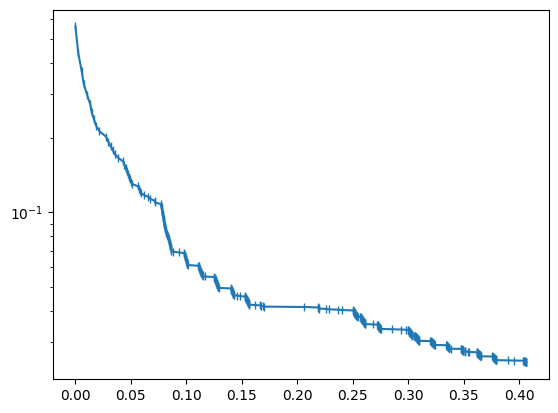

In [188]:
plt.yscale('log')
benchmark(lambda: solve_poisson_jacobi(p.copy(), u, h, X * 3))
benchmark(lambda: solve_poisson_mg(p.copy(), u, h, X, 10, 10, 300, restriction_square, prolongation_linear))

In [ ]:
benchmark(lambda: solve_poisson_mg(p.copy(), u, h, X, 2, restriction_square, prolongation_linear))